In [18]:
# %autoreload 2

from IPython import display

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# from utils import Logger

import tensorflow as tf
from tensorflow import nn, layers
from tensorflow.contrib import layers as clayers 

import numpy as np



In [19]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise


In [20]:
DATA_FOLDER = '/Users/shreyajain/PycharmProjects/GAN/gans/data/MNIST'
IMAGE_PIXELS = 28*28
IMAGE_PIXELS = 64*64
NOISE_SIZE = 100
BATCH_SIZE = 100

In [21]:
def noise(n_rows, n_cols):
    return np.random.normal(size=(n_rows, n_cols))

def xavier_init(size):
    in_dim = size[0] if len(size) == 1 else size[1]
    stddev = 1. / np.sqrt(float(in_dim))
    return tf.random_uniform(shape=size, minval=-stddev, maxval=stddev)

def images_to_vectors(images):
    return images.reshape(images.shape[0], 784)

def vectors_to_images(vectors):
    return vectors.reshape(vectors.shape[0], 28, 28, 1)

In [22]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.Resize(64),
        transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [23]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [24]:
IMAGES_SHAPE = (64, 64, 1)
NOISE_SIZE = 100

In [36]:
def default_conv2d(inputs, filters):
    return layers.conv2d(
        inputs,
        filters=filters,
        kernel_size=4,
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        use_bias=False,
    )

def default_conv2d_transpose(inputs, filters):
    return layers.conv2d_transpose(
        inputs,
        filters=filters,
        kernel_size=4,
        strides=(2, 2),
        padding='same',
        data_format='channels_last',
        use_bias=False,
    )

def noise(n_rows, n_cols):
    return np.random.normal(size=(n_rows, n_cols))

tf.reset_default_graph()

In [37]:
def discriminator(x):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        with tf.variable_scope("conv1"):
            conv1 = default_conv2d(x, 128)
            conv1 = nn.leaky_relu(conv1,alpha=0.2)
            print ("conv1 ", conv1.shape)
        
        with tf.variable_scope("conv2"):
            conv2 = default_conv2d(conv1, 256)
            conv2 = layers.batch_normalization(conv2)
            conv2 = nn.leaky_relu(conv2,alpha=0.2)
            print ("conv2 ", conv2.shape)
            
        with tf.variable_scope("conv3"):
            conv3 = default_conv2d(conv2, 512)
            conv3 = layers.batch_normalization(conv3)
            conv3 = nn.leaky_relu(conv3,alpha=0.2)
            print ("conv3 ", conv3.shape)
            
        with tf.variable_scope("conv5"):
            conv4 = default_conv2d(conv3, 1024)
            conv4 = layers.batch_normalization(conv4)
            conv4 = nn.leaky_relu(conv4,alpha=0.2)
            print ("conv4 ", conv4.shape)
        
        with tf.variable_scope("linear2"):
            linear = clayers.flatten(conv4)
            linear = clayers.fully_connected(linear, 1)
            print ("linear ", linear.shape)
        
        with tf.variable_scope("out"):
            out = nn.sigmoid(linear)
    return out

In [38]:
def generator(z):
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
        
        with tf.variable_scope("linear"):
            linear = clayers.fully_connected(z, 1024 * 4 * 4)
            print ("linear ", linear.shape)
            
        with tf.variable_scope("conv1_transp"):
            # Reshape as 4x4 images
            conv1 = tf.reshape(linear, (-1, 4, 4, 1024))
            print ("conv1 a", conv1.shape)
            conv1 = default_conv2d_transpose(conv1, 512)
            conv1 = layers.batch_normalization(conv1)
            conv1 = nn.relu(conv1)
            print ("conv1 ", conv1.shape)
        
        with tf.variable_scope("conv2_transp"):
            conv2 = default_conv2d_transpose(conv1, 256)
            conv2 = layers.batch_normalization(conv2)
            conv2 = nn.relu(conv2)
            print ("conv2 ", conv2.shape)
            
        with tf.variable_scope("conv3_transp"):
            conv3 = default_conv2d_transpose(conv2, 128)
            conv3 = layers.batch_normalization(conv3)
            conv3 = nn.relu(conv3)
            print ("conv3 ", conv3.shape)
            
        with tf.variable_scope("conv6_transp"):
            # conv4 = layers.conv2d_transpose(conv3, 1, kernel_size=4,strides=(2, 2), padding='same')
            conv4 = default_conv2d_transpose(conv3, 1)
            print ("conv4 ", conv4.shape)
    
        with tf.variable_scope("out"):
            out = tf.tanh(conv4)
    return out

In [39]:
## Real Input
X = tf.placeholder(tf.float32, shape=(None, )+IMAGES_SHAPE)
## Latent Variables / Noise
Z = tf.placeholder(tf.float32, shape=(None, NOISE_SIZE))

In [40]:
# Generator
print ("Z shape ", Z.shape)
G_sample = generator(Z)
print ("G_sample ", G_sample.shape)
# Discriminator
print ("X ", X.shape)
D_real = discriminator(X)
D_fake = discriminator(G_sample)

Z shape  (?, 100)
linear  (?, 16384)
conv1 a (?, 4, 4, 1024)
conv1  (?, 8, 8, 512)
conv2  (?, 16, 16, 256)
conv3  (?, 32, 32, 128)
conv4  (?, 64, 64, 1)
G_sample  (?, 64, 64, 1)
X  (?, 64, 64, 1)
conv1  (?, 32, 32, 128)
conv2  (?, 16, 16, 256)
conv3  (?, 8, 8, 512)
conv4  (?, 4, 4, 1024)
linear  (?, 1)
conv1  (?, 32, 32, 128)
conv2  (?, 16, 16, 256)
conv3  (?, 8, 8, 512)
conv4  (?, 4, 4, 1024)
linear  (?, 1)


In [41]:
# Generator
G_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_fake, labels=tf.ones_like(D_fake)
    )
)

# Discriminator
D_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_real, labels=tf.ones_like(D_real)
    )
)

D_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=D_fake, labels=tf.zeros_like(D_fake)
    )
)

D_loss = D_loss_real + D_loss_fake

In [49]:
# Obtain trainable variables for both networks
train_vars = tf.trainable_variables()

G_vars = [var for var in train_vars if 'generator' in var.name]
D_vars = [var for var in train_vars if 'discriminator' in var.name]

num_epochs = 200
num_epochs = 1

In [43]:
G_opt = tf.train.AdamOptimizer(2e-4).minimize(G_loss, var_list=G_vars,)
D_opt = tf.train.AdamOptimizer(2e-4).minimize(D_loss, var_list=D_vars,)

In [44]:
num_test_samples = 16
test_noise = noise(num_test_samples, NOISE_SIZE)

In [50]:
BATCH_SIZE = 100
NUM_EPOCHS = 200
NUM_EPOCHS = 1

# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()
# Init Logger
logger = Logger(model_name='DCGAN1', data_name='CIFAR10')

In [46]:
print ("trainable_variables ", tf.trainable_variables())

trainable_variables  [<tf.Variable 'generator/linear/fully_connected/weights:0' shape=(100, 16384) dtype=float32_ref>, <tf.Variable 'generator/linear/fully_connected/biases:0' shape=(16384,) dtype=float32_ref>, <tf.Variable 'generator/conv1_transp/conv2d_transpose/kernel:0' shape=(4, 4, 512, 1024) dtype=float32_ref>, <tf.Variable 'generator/conv1_transp/batch_normalization/gamma:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'generator/conv1_transp/batch_normalization/beta:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'generator/conv2_transp/conv2d_transpose/kernel:0' shape=(4, 4, 256, 512) dtype=float32_ref>, <tf.Variable 'generator/conv2_transp/batch_normalization/gamma:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator/conv2_transp/batch_normalization/beta:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'generator/conv3_transp/conv2d_transpose/kernel:0' shape=(4, 4, 128, 256) dtype=float32_ref>, <tf.Variable 'generator/conv3_transp/batch_normalization/gamma:0' shape=(

In [47]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    print ("name", variable.value)
    shape = variable.get_shape()
    print("shape ", shape)
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print("variable_parameters ",variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)

name <bound method RefVariable.value of <tf.Variable 'generator/linear/fully_connected/weights:0' shape=(100, 16384) dtype=float32_ref>>
shape  (100, 16384)
variable_parameters  1638400
name <bound method RefVariable.value of <tf.Variable 'generator/linear/fully_connected/biases:0' shape=(16384,) dtype=float32_ref>>
shape  (16384,)
variable_parameters  16384
name <bound method RefVariable.value of <tf.Variable 'generator/conv1_transp/conv2d_transpose/kernel:0' shape=(4, 4, 512, 1024) dtype=float32_ref>>
shape  (4, 4, 512, 1024)
variable_parameters  8388608
name <bound method RefVariable.value of <tf.Variable 'generator/conv1_transp/batch_normalization/gamma:0' shape=(512,) dtype=float32_ref>>
shape  (512,)
variable_parameters  512
name <bound method RefVariable.value of <tf.Variable 'generator/conv1_transp/batch_normalization/beta:0' shape=(512,) dtype=float32_ref>>
shape  (512,)
variable_parameters  512
name <bound method RefVariable.value of <tf.Variable 'generator/conv2_transp/conv2

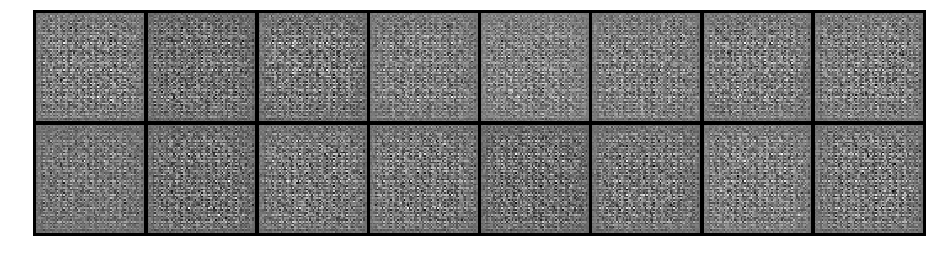

Epoch: [0/1], Batch Num: [0/600]
Discriminator Loss: 1.4471, Generator Loss: 0.4741
D(x): 0.5027, D(G(z)): 0.5000


KeyboardInterrupt: 

In [53]:
# Start interactive session
# session = tf.InteractiveSession()

with tf.Session() as sess:
    writer = tf.summary.FileWriter('/Users/shreyajain/PycharmProjects/GAN/gans/graphs', session.graph)
    # Init Variables
    tf.global_variables_initializer().run()

    loss_list_discriminator = []
    loss_list_generator = []
    import matplotlib.pyplot as plt


    # Iterate through epochs
    for epoch in range(NUM_EPOCHS):
        for n_batch, (batch,_) in enumerate(data_loader):

            # 1. Train Discriminator
            X_batch = batch.permute(0, 2, 3, 1).numpy()
            feed_dict = {X: X_batch, Z: noise(BATCH_SIZE, NOISE_SIZE)}
            _, d_error, d_pred_real, d_pred_fake = session.run(
                [D_opt, D_loss, D_real, D_fake], feed_dict=feed_dict
            )

            loss_list_discriminator.append(d_error)
            # 2. Train Generator
            feed_dict = {Z: noise(BATCH_SIZE, NOISE_SIZE)}
            _, g_error = session.run(
                [G_opt, G_loss], feed_dict=feed_dict
            )
            loss_list_generator.append(g_error)

            if n_batch % 100 == 0:
                display.clear_output(True)
                # Generate images from test noise
                test_images = session.run(
                    G_sample, feed_dict={Z: test_noise}
                )
                # Log Images
                logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches, format='NHWC');
                # Log Status
                logger.display_status(
                    epoch, num_epochs, n_batch, num_batches,
                    d_error, g_error, d_pred_real, d_pred_fake
                )


plt.plot(loss_list_generator)
plt.plot(loss_list_discriminator)
plt.show()


In [ ]:
# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()

loss_list_discriminator = []
loss_list_generator = []
import matplotlib.pyplot as plt

# Iterate through epochs
for epoch in range(NUM_EPOCHS):
    for n_batch, (batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        X_batch = batch.permute(0, 2, 3, 1).numpy()
        feed_dict = {X: X_batch, Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, d_error, d_pred_real, d_pred_fake = session.run(
            [D_opt, D_loss, D_real, D_fake], feed_dict=feed_dict
        )
        
        loss_list_discriminator.append(d_error)
        # 2. Train Generator
        feed_dict = {Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, g_error = session.run(
            [G_opt, G_loss], feed_dict=feed_dict
        )
        loss_list_generator.append(g_error)
        
        if n_batch % 100 == 0:
            display.clear_output(True)
            # Generate images from test noise
            test_images = session.run(
                G_sample, feed_dict={Z: test_noise}
            )
            # Log Images
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches, format='NHWC');
            # Log Status
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
            
plt.plot(loss_list_generator)
plt.plot(loss_list_discriminator)
plt.show()
